In [1]:
import sys
from pathlib import Path

#Find root directory
root_dir = Path().absolute()
if root_dir.parts[-2:] == ('notebooks', 'algae_bloom'):
    root_dir = Path(*root_dir.parts[:-2])
root_dir = str(root_dir)

print(f"Root dir: {root_dir}")

# Add the root directory to the `PYTHONPATH` 
if root_dir not in sys.path:
    sys.path.append(root_dir)
    print(f"Added the following directory to the PYTHONPATH: {root_dir}")

Root dir: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-project
Added the following directory to the PYTHONPATH: /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-project


# <span style="font-width:bold; font-size: 3rem; color:#333;">Training Pipeline</span>

## 🌐 Imports

In [2]:
import os
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

## 🌳 Connect to Hopsworks and get variables from Hopsworks secret </span>

In [3]:
project = hopsworks.login(engine="python")
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()

#Get the dictionary with all batch locations
bath_locations_json = secrets.get_secret("BATH_LOCATIONS_JSON").value
bath_locations = json.loads(bath_locations_json)
print(bath_locations)

2025-12-19 12:35:18,651 INFO: Initializing external client
2025-12-19 12:35:18,653 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-12-19 12:35:20,259 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286295
[{'bath_location': 'Bergabadet', 'latitude': 59.057008, 'longitude': 17.440774}, {'bath_location': 'Bränningestrand', 'latitude': 59.148617, 'longitude': 17.6674}, {'bath_location': 'Eklundsnäsbadet', 'latitude': 59.16883, 'longitude': 17.59184}, {'bath_location': 'Farstanäsbadet', 'latitude': 59.096884, 'longitude': 17.65387}, {'bath_location': 'Mälarbadet', 'latitude': 59.222657, 'longitude': 17.611886}, {'bath_location': 'Nya Malmsjöbadet', 'latitude': 59.234823, 'longitude': 17.536534}, {'bath_location': 'Näsets udde(Glashyttan)', 'latitude': 59.158419, 'longitude': 17.66072}, {'bath_location': 'Underåsbadet', 'latitude': 59.26482, 'longitude': 17.536534}, {'bath_location': 'Åbynäsbadet', 'latitude': 59.018397, 'longitude': 17.619576}]


## 🌾 Get feature groups

In [4]:
#Select version of feature group
wt_version = 1
w_version = 1

#Retrieve feature groups
water_temperature_fg = fs.get_feature_group( 
    name='water_temperature',
    version=wt_version,
)

weather_fg = fs.get_feature_group(
    name='weather',
    version=w_version,
)

## 👀 Create feature view

In [5]:
# Select features for training data from both feature groups
from hsfs.feature import Feature

selected_features = water_temperature_fg.select(['temp_water', 'alias', 'formatted_time','lagged_wt_1_day', 'lagged_wt_2_days', 'lagged_wt_3_days']).join(weather_fg.select(['temperature_2m', 'precipitation', 'wind_speed_10m', 'wind_direction_10m']), on=['alias'])

In [6]:
#Select version of feature group
fv_version = 1

#Create feature view

feature_view = fs.get_or_create_feature_view(
        name='water_temperature_fv',
        description="weather features with water teamperature as the target",
        version=fv_version,
        labels=['temp_water'],
        query=selected_features,

    )

## 🧩 Create train and test datasets

In [7]:
start_date_test_data = "2025-01-01" #<-- KOLLA OM VI VILL ÄNDRA

# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
#Split test and train data
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start=test_start
)

X_train

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.52s) 


,alias,formatted_time,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
0,Åbynäsbadet,2022-01-04 11:35:00+00:00,2.4,1.8,2.1,0.928000,0.0,15.188416,238.570480
1,Åbynäsbadet,2022-01-05 11:35:00+00:00,2.1,2.4,1.8,0.528000,0.0,8.854829,296.564972
2,Åbynäsbadet,2022-01-06 11:36:00+00:00,2.7,2.1,2.4,-4.572000,0.0,12.783802,302.347412
3,Åbynäsbadet,2022-01-07 11:36:00+00:00,2.5,2.7,2.1,-5.072000,0.0,4.896529,72.897186
4,Åbynäsbadet,2022-01-08 11:37:00+00:00,2.3,2.5,2.7,0.378000,0.0,4.104631,232.124954
...,...,...,...,...,...,...,...,...,...
6936,Bergabadet,2024-08-02 14:25:00+00:00,22.2,21.9,22.8,20.252501,0.0,9.693296,328.671356
6937,Bergabadet,2024-08-03 14:25:00+00:00,22.3,22.2,21.9,22.752501,0.0,8.669949,318.366547
6938,Bergabadet,2024-08-04 14:25:00+00:00,22.9,22.3,22.2,19.902500,0.1,2.811690,140.194473
6939,Bergabadet,2024-08-05 14:25:00+00:00,21.4,22.9,22.3,22.552500,0.0,6.162207,353.290253


In [10]:
#Handle categorical features, converts into numerical values for XGBoost
# if running_a:
#     categorical_transformer=Pipeline(steps=[("encoder", OneHotEncoder(handle_unknown="ignore"))])
#     preprocessor = ColumnTransformer(transformers=[("cat", categorical_transformer, ['street'])], remainder="passthrough")


In [ ]:
#Double check
# if running_a:
#     X_train = data_sets[locations[0]['street']][0]
# X_train

,date,lagged_aq_1_day,lagged_aq_2_days,lagged_aq_3_days,weather_date,weather_temperature_2m_mean,weather_precipitation_sum,weather_wind_speed_10m_max,weather_wind_direction_10m_dominant,weather_city
0,2019-03-18 00:00:00+00:00,NaN,NaN,NaN,2019-03-18 00:00:00+00:00,5.330000,0.0,15.941944,239.008041,edinburgh
1,2019-03-19 00:00:00+00:00,11.0,NaN,NaN,2019-03-19 00:00:00+00:00,8.850833,0.1,29.268686,235.155060,edinburgh
2,2019-03-20 00:00:00+00:00,11.0,11.0,NaN,2019-03-20 00:00:00+00:00,11.767501,0.3,30.631746,230.071609,edinburgh
3,2019-03-21 00:00:00+00:00,8.0,11.0,11.0,2019-03-21 00:00:00+00:00,11.617499,0.5,29.091030,228.964096,edinburgh
4,2019-03-22 00:00:00+00:00,14.0,8.0,11.0,2019-03-22 00:00:00+00:00,8.973750,2.1,38.773186,226.136246,edinburgh
...,...,...,...,...,...,...,...,...,...,...
2187,2025-04-26 00:00:00+00:00,29.0,29.0,41.0,2025-04-26 00:00:00+00:00,10.725833,1.1,19.980000,173.277206,edinburgh
2188,2025-04-27 00:00:00+00:00,45.0,29.0,29.0,2025-04-27 00:00:00+00:00,12.955001,0.2,29.758307,209.440353,edinburgh
2189,2025-04-28 00:00:00+00:00,15.0,45.0,29.0,2025-04-28 00:00:00+00:00,14.248750,0.0,24.696104,236.274353,edinburgh
2190,2025-04-29 00:00:00+00:00,26.0,15.0,45.0,2025-04-29 00:00:00+00:00,14.373750,0.4,10.472535,224.629211,edinburgh


In [9]:
#Drop formatted_time since this will not be feature for training
X_features = X_train.drop(columns=['formatted_time'])
X_test_features = X_test.drop(columns=['formatted_time'])  
#Model-dependent transformation to create categorical feature from alias
X_features['alias'] = X_train['alias'].astype('category').cat.codes
X_test_features['alias'] = X_test['alias'].astype('category').cat.codes

X_features

,alias,lagged_wt_1_day,lagged_wt_2_days,lagged_wt_3_days,temperature_2m,precipitation,wind_speed_10m,wind_direction_10m
0,8,2.4,1.8,2.1,0.928000,0.0,15.188416,238.570480
1,8,2.1,2.4,1.8,0.528000,0.0,8.854829,296.564972
2,8,2.7,2.1,2.4,-4.572000,0.0,12.783802,302.347412
3,8,2.5,2.7,2.1,-5.072000,0.0,4.896529,72.897186
4,8,2.3,2.5,2.7,0.378000,0.0,4.104631,232.124954
...,...,...,...,...,...,...,...,...
6936,0,22.2,21.9,22.8,20.252501,0.0,9.693296,328.671356
6937,0,22.3,22.2,21.9,22.752501,0.0,8.669949,318.366547
6938,0,22.9,22.3,22.2,19.902500,0.1,2.811690,140.194473
6939,0,21.4,22.9,22.3,22.552500,0.0,6.162207,353.290253


In [10]:
#Check y_train
y_train

,temp_water
0,2.1
1,2.7
2,2.5
3,2.3
4,2.0
...,...
6936,22.3
6937,22.9
6938,21.4
6939,23.1


---

## 🏋️‍♀️ Train model

In [11]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [12]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 0.5662289249483387
R squared: 0.98838985115596


In [13]:
#Adding the predictions to the dataframe
df = y_test
df['predicted_temp_water'] = y_pred

In [14]:
#Adding the time and name of bath location to dataframe again and sort by that, for plot
df['formatted_time'] = X_test['formatted_time']
df['alias'] = X_test['alias']
df = df.sort_values(by=['formatted_time'])

In [15]:
# Creating a directory for the model artifacts if it doesn't exist

model_dir = "water_temperature_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)
   


Bergabadet


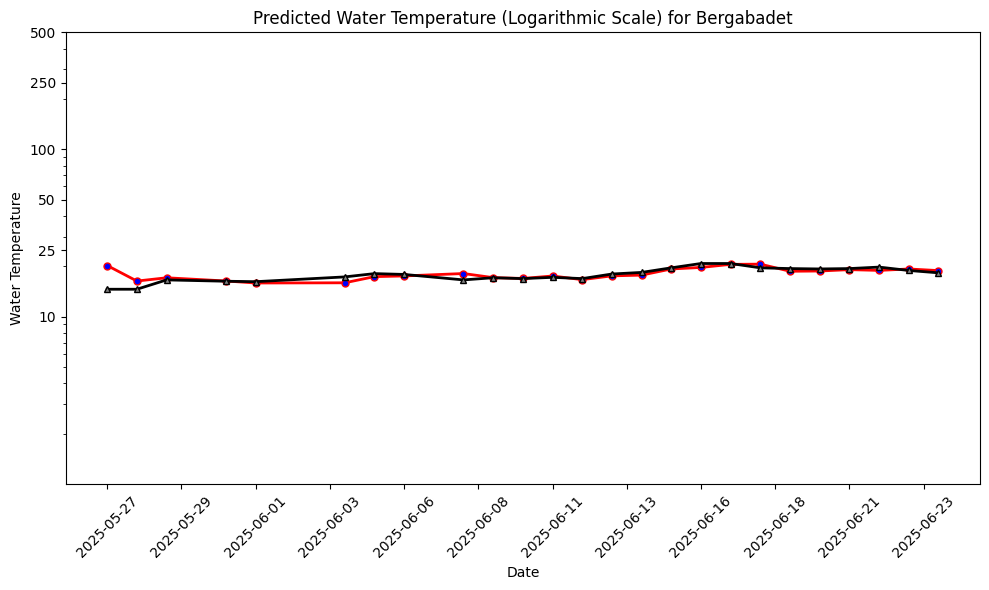

Bränningestrand
No data for: Bränningestrand
Eklundsnäsbadet


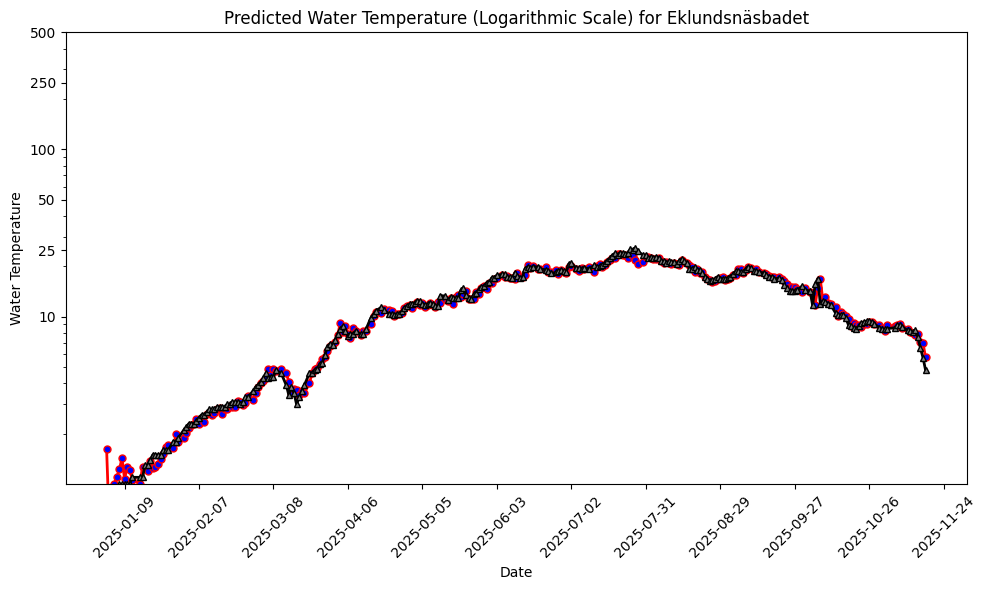

Farstanäsbadet


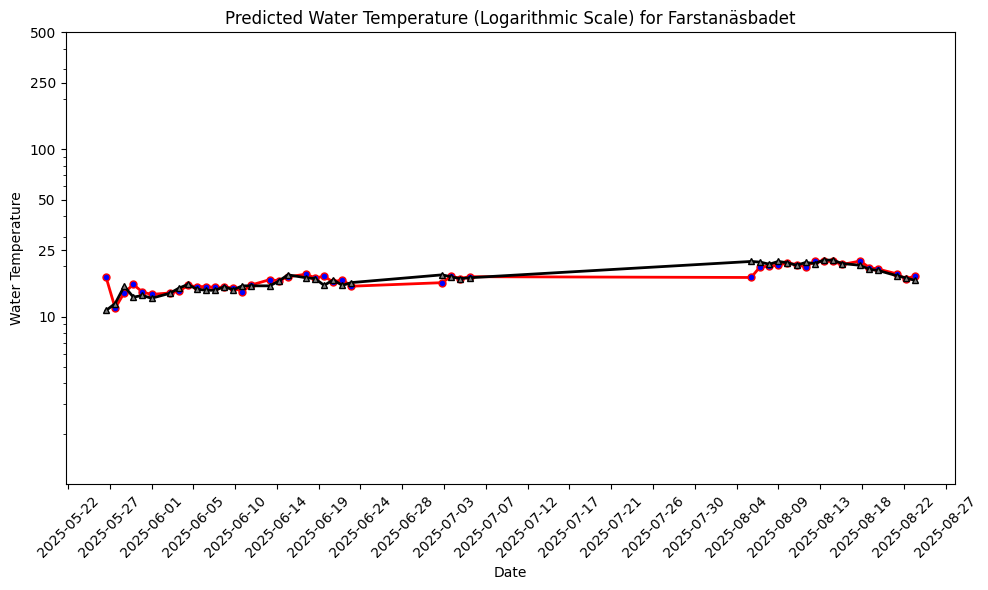

Mälarbadet


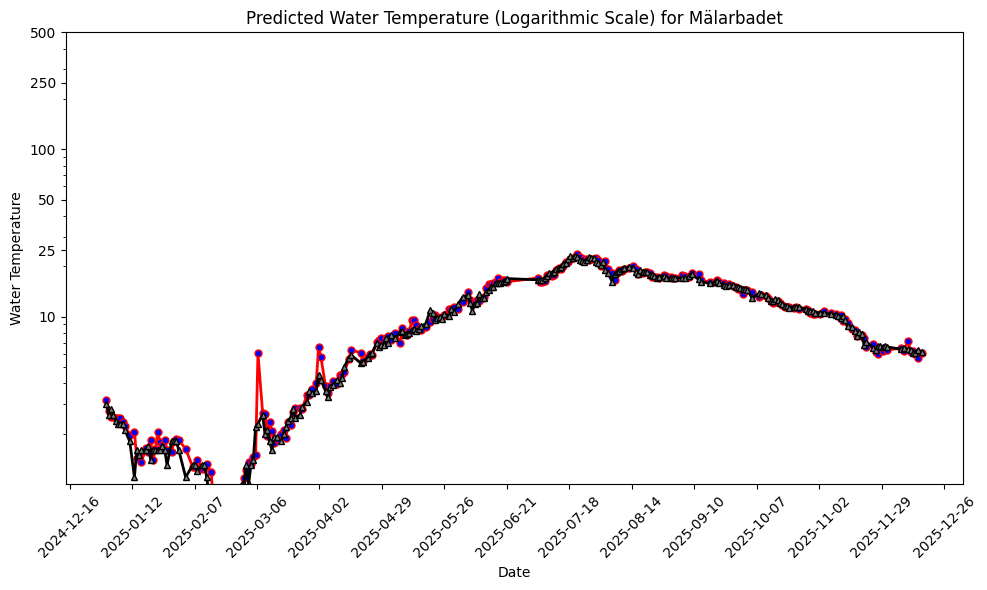

Nya Malmsjöbadet
No data for: Nya Malmsjöbadet
Näsets udde(Glashyttan)


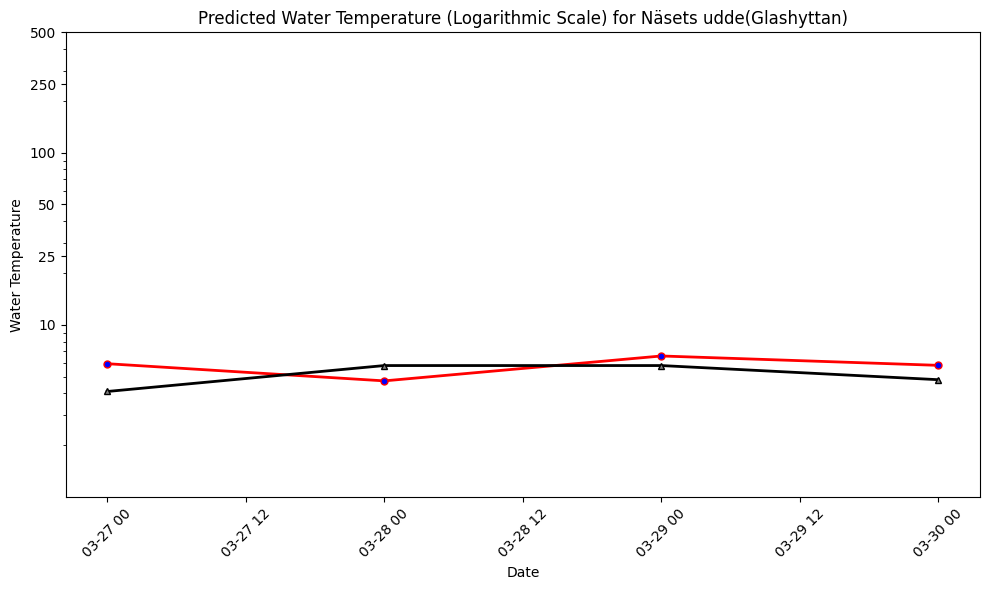

Underåsbadet
No data for: Underåsbadet
Åbynäsbadet


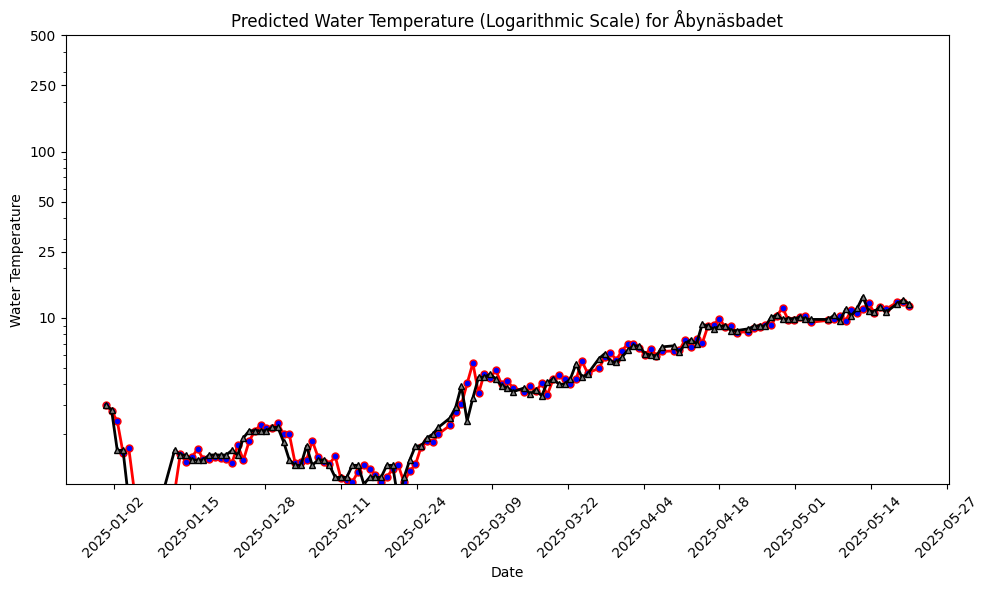

In [16]:
file_path = images_dir + "/water_temp_hindcast.png"

for location_dict in bath_locations:
    bath_location = location_dict["bath_location"]
    print(bath_location)

    file_path = images_dir + "/water_temp_hindcast" + str(bath_location) + ".png"

    location_df = df[df["alias"] == bath_location]

    if location_df.empty:
        print("No data for:", bath_location)
        continue

    plt = util.plot_water_temp_forecast(bath_location, location_df, str(file_path), hindcast=True) 
    plt.show()


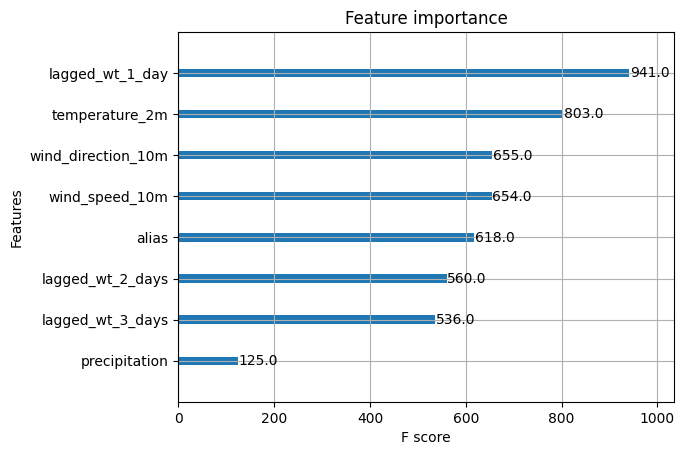

In [17]:
# Plotting feature importances using the plot_importance function from XGBoost

plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

---

## <span style='color:#ff5f27'>🗄 Model Registry</span>

One of the features in Hopsworks is the model registry. This is where you can store different versions of models and compare their performance. Models from the registry can then be served as API endpoints.

In [ ]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_regressor.save_model(model_dir + "/model.json")


In [ ]:

 
res_dict = { 
        "MSE": str(mse),
        "R squared": str(r2),
    }

In [ ]:
mr = project.get_model_registry()

# Save model

wt_model = mr.python.create_model(
    name="water_temperature_xgboost_model", 
    metrics= res_dict,
    feature_view=feature_view,
    description="Water Temperature Predictor",
)
wt_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/13


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/14


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/15


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/16


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/17


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/a…

Uploading /Users/isabell/Documents/KTH/KTH femman/Scalable Machine learning/id2223-lab1/notebooks/airquality/m…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1272015/models/air_quality_xgboost_model/18
